In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from imblearn.over_sampling import SMOTE, ADASYN

from sklearn import metrics
#from sklearn.metrics import confusion_matrix
#sfrom sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

from sklearn.utils.multiclass import unique_labels

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline

In [13]:
def printTree(feature_cols,tree):
    dot_data = StringIO()
    export_graphviz(tree, out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True, feature_names = feature_cols,class_names=['0','1'])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    graph.write_png('magic_tree.png')
    Image(graph.create_png())

In [3]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [4]:
def calcMetrics(Yt, Yp, classes, model, norm=True, cols=None, print_metrics=False):
    # Metrics
    acc = metrics.accuracy_score(Yt, Yp)
    acc_bal = metrics.balanced_accuracy_score(Yt, Yp)
    prec = metrics.precision_score(Yt, Yp)
    recall = metrics.recall_score(Yt, Yp)
    f1 = metrics.f1_score(Yt, Yp)
    roc_auc = roc_auc_score(Yt, Yp)
    
    feature_imp = pd.Series(model.feature_importances_,index=cols).sort_values(ascending=True)
    
    if(print_metrics):
        print("")
        plot_confusion_matrix(Yt, Yp, classes, normalize=norm)
        print("")
        print("Accuracy:", acc)
        print("Balanced Accuracy: ", acc_bal)
        print("Precision: ", prec)
        print("Recall: ", recall)
        print("F1 Score: ", f1)
        print("ROC AuC Score: ", roc_auc)
       
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.barh(feature_imp.index,feature_imp.values, align='center')
        ax.set_xlabel('Performance')
        ax.set_title('How fast do you want to go today?')
        plt.grid(True)
        
        plt.show()
    
    return acc, acc_bal, prec, recall, f1, roc_auc, feature_imp
    
    

In [5]:
def trainDecisionTree(Xtr, Xte, Ytr, Yte, feat_cols, print_metrics=False):
    tree = DecisionTreeClassifier()
    tree = tree.fit(Xtr,Ytr)
    y_pred = tree.predict(Xte)
    
    return calcMetrics(Yte, y_pred, [0,1], tree, norm=True, cols=feat_cols, print_metrics=print_metrics)


def trainRandomForest(Xtr, Xte, Ytr, Yte, feat_cols, print_metrics=False):
    forest=RandomForestClassifier(n_estimators=1000)
    forest.fit(Xtr,Ytr)
    y_pred=forest.predict(Xte)
    
    return calcMetrics(Yte, y_pred, [0,1], forest, norm=True, cols=feat_cols, print_metrics=print_metrics)


In [6]:
def trainGradientBoosting(Xtr, Xte, Ytr, Yte, feat_cols, print_metrics=False):
    model_GB = GradientBoostingClassifier(n_estimators=1000)
    model_GB.fit(Xtr , Ytr)
    y_pred = model_GB.predict(Xte)
    
    return calcMetrics(Yte, y_pred, [0,1], model_GB, norm=True,
                       cols=feat_cols, print_metrics=print_metrics)

    #print(classification_report(Y_test, y_pred,target_names=target_names))
    
def trainADA(Xtr, Xte, Ytr, Yte, feat_cols, print_metrics=False):
    model_ad = AdaBoostClassifier()
    model_ad.fit(Xtr , Ytr)
    y_pred = model_ad.predict(Xte)
    
    return calcMetrics(Yte, y_pred, [0,1], model_ad, norm=True,
                       cols=feat_cols, print_metrics=print_metrics)

    #print(classification_report(Y_test, y_pred,target_names=target_names))

In [7]:
feature_files = [
    "features/features_sub.csv",
    "features/features_div.csv"
]

feature_cols = [
        'duration',
        #'show_order',
        'fix_freq','sacc_freq',
        'pupil_diam_right_mean','pupil_diam_right_std','pupil_diam_right_min','pupil_diam_right_max',
        'pupil_diam_left_mean','pupil_diam_left_std','pupil_diam_left_min','pupil_diam_left_max',
        'sre_fix_freq','sre_sacc_freq',
        'sre_pupil_diam_right_mean','sre_pupil_diam_right_std',
        'sre_pupil_diam_right_min','sre_pupil_diam_right_max',
        'sre_pupil_diam_left_mean','sre_pupil_diam_left_std',
        'sre_pupil_diam_left_min','sre_pupil_diam_left_max',
        'srl_fix_freq','srl_sacc_freq',
        'srl_pupil_diam_right_mean','srl_pupil_diam_right_std',
        'srl_pupil_diam_right_min','srl_pupil_diam_right_max',
        'srl_pupil_diam_left_mean','srl_pupil_diam_left_std',
        'srl_pupil_diam_left_min','srl_pupil_diam_left_max',
    ]

In [8]:
class ModelMetricAggregator:
    
    def __init__(self, model, mode=''):
        self.model = model
        self.mode = mode
        self.accuracy = []
        self.balanced_accuracy = []
        self.precision = []
        self.recall = []
        self.f1_score = []
        self.roc_auc = []
        
    def addMetrics(self,acc, bal_acc, prec, rec, f1, roc_auc):
        self.accuracy.append(acc)
        self.balanced_accuracy.append(bal_acc)
        self.precision.append(prec)
        self.recall.append(rec)
        self.f1_score.append(f1)
        self.roc_auc = roc_auc
        
    def getMetrics(self):
        return [
            self.model,
            self.mode,
            np.mean(self.accuracy),
            np.mean(self.balanced_accuracy),
            np.mean(self.precision),
            np.mean(self.recall),
            np.mean(self.f1_score),
            np.mean(self.roc_auc)
        ]

In [9]:
metrics_cols = ['baseline','model', 'accuracy', 'bal_accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
mDF = pd.DataFrame(columns=metrics_cols)

for file in feature_files:
    print("Process File: {}".format(file))
    
    f = file.split('/')[-1]
    mode = file.split('/')[-1].split('.')[0].split('_')
    
    # Load the file
    features = pd.read_csv(file, sep='\t')
    
    if(mode[1] == "sub"):
        features = features.fillna(0)
    else:
        features = features.fillna(1)
    
    # Extract Feature Columns
    X = features[feature_cols]
    y = features['label']
    
    # Rebalance the dataset with SMOTE
    #X, y = SMOTE().fit_resample(X, y)
    
    # Create Folds for KFold Cross Validation
    # 102 for leave one out
    splitter = KFold(n_splits=10, random_state=11)
    #splitter = LeaveOneOut()
    
    # Initialize Metrics accumulators
    tree = ModelMetricAggregator("tree", mode[1])
    forest = ModelMetricAggregator("forest", mode[1])
    gboost = ModelMetricAggregator("gb", mode[1])
    ada = ModelMetricAggregator("ada", mode[1])
    
    for train_index, test_index in splitter.split(X):
        #print("train index: ", train_index)
        
        # Generate Train and Test set
        X_train = X.iloc[train_index]        
        y_train = y.iloc[train_index]
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]
        
        # Smothe inside the fold
        X_train, y_train = SMOTE().fit_resample(X_train, y_train)
        
        # Train Decision Tree
        t_acc, t_bal, t_prec, t_rec, t_f1, t_auc, t_best_feat =  \
                        trainDecisionTree(X_train, X_test, y_train, y_test, feature_cols)
        tree.addMetrics(t_acc, t_bal, t_prec, t_rec, t_f1, t_auc)
        
        # Train Random Forest
        f_acc, f_bal, f_prec, f_rec, f_f1, f_auc, f_best_feat = \
                        trainRandomForest(X_train, X_test, y_train, y_test, feature_cols)
        forest.addMetrics(f_acc, f_bal, f_prec, f_rec, f_f1, f_auc)
        
        g_acc, g_bal, g_prec, g_rec, g_f1, g_auc, g_best_feat =  \
                        trainGradientBoosting(X_train, X_test, y_train, y_test, feature_cols)
        gboost.addMetrics(g_acc, g_bal, g_prec, g_rec, g_f1, g_auc)
        
        a_acc, a_bacc, a_prec, a_rec, a_f1, a_auc, a_best = trainADA(X_train, X_test, y_train, y_test, feature_cols)
        ada.addMetrics(a_acc, a_bacc, a_prec, a_rec, a_f1, a_auc)
        
    # Calculate KFold Mean results
    tree_row = tree.getMetrics()
    forest_row = forest.getMetrics()
    g_row = gboost.getMetrics()
    ada_row = ada.getMetrics()
    
    tree_series = pd.Series(tree_row, index=metrics_cols)
    forest_series = pd.Series(forest_row, index=metrics_cols)
    g_series = pd.Series(g_row, index=metrics_cols)
    ada_series = pd.Series(ada_row, index=metrics_cols)
   
    mDF = mDF.append(tree_series, ignore_index=True)
    mDF = mDF.append(forest_series, ignore_index=True)
    mDF = mDF.append(g_series, ignore_index=True)
    mDF = mDF.append(ada_series, ignore_index=True)


#mDF.to_csv("metrics.csv")    
idx = mDF[['accuracy', 'bal_accuracy', 'precision', 'recall', 'f1_score']].idxmax()
print(idx)

mDF


Process File: features/features_sub.csv


/home/dario/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dario/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dario/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dario/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dario/anaconda3/lib/python3.7/site-packages/sklearn/me

Process File: features/features_div.csv


/home/dario/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dario/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dario/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dario/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dario/anaconda3/lib/python3.7/site-packages/sklearn/me

accuracy        3
bal_accuracy    3
precision       3
recall          3
f1_score        3
dtype: int64


,baseline,model,accuracy,bal_accuracy,precision,recall,f1_score,roc_auc
0,tree,sub,0.625455,0.439861,0.041667,0.15,0.061905,0.1875
1,forest,sub,0.732727,0.486111,0.020000,0.10,0.033333,0.4375
2,gb,sub,0.703636,0.504722,0.100000,0.20,0.123333,0.5625
3,ada,sub,0.763636,0.616389,0.300000,0.40,0.320000,0.6250
4,tree,div,0.636364,0.511389,0.105952,0.30,0.145000,0.3125
5,forest,div,0.752727,0.536667,0.175000,0.20,0.156667,0.3750
6,gb,div,0.745455,0.530972,0.133333,0.20,0.156667,0.3750
7,ada,div,0.733636,0.522778,0.200000,0.20,0.200000,0.4375


In [10]:
# 0 	tree 	sub 	0.637019 	0.524242 	0.199107 	0.354167 	0.245040 	0.35

# 3 	ada 	sub 	0.763636 	0.616389 	0.300000 	0.40 	0.320000 	0.6250

In [11]:
mDF.to_csv("metrics_ada_best.csv") 


Normalized confusion matrix
[[0.72413793 0.27586207]
 [0.17857143 0.82142857]]

Accuracy: 0.7719298245614035
Balanced Accuracy:  0.7727832512315271
Precision:  0.7419354838709677
Recall:  0.8214285714285714
F1 Score:  0.7796610169491526
ROC AuC Score:  0.772783251231527


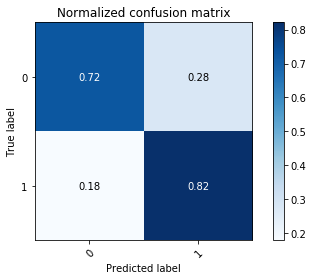

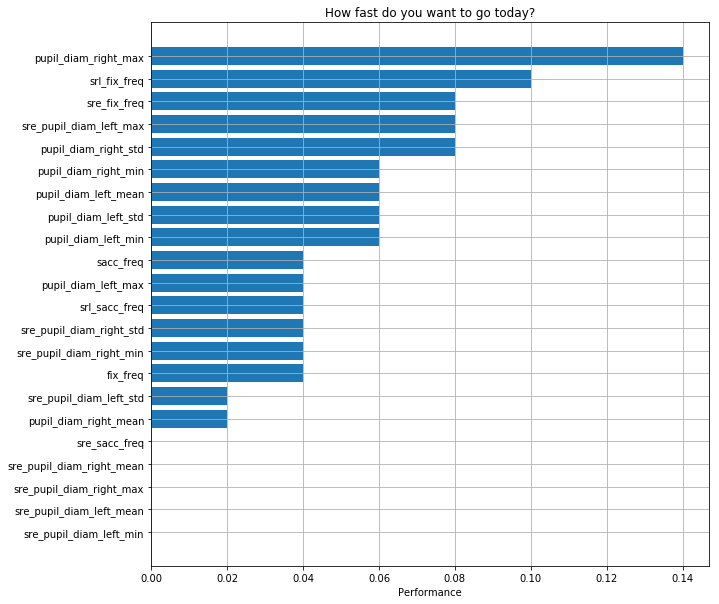

(0.7719298245614035,
 0.7727832512315271,
 0.7419354838709677,
 0.8214285714285714,
 0.7796610169491526,
 0.772783251231527,
 sre_pupil_diam_left_min      0.00
 sre_pupil_diam_left_mean     0.00
 sre_pupil_diam_right_max     0.00
 sre_pupil_diam_right_mean    0.00
 sre_sacc_freq                0.00
 pupil_diam_right_mean        0.02
 sre_pupil_diam_left_std      0.02
 fix_freq                     0.04
 sre_pupil_diam_right_min     0.04
 sre_pupil_diam_right_std     0.04
 srl_sacc_freq                0.04
 pupil_diam_left_max          0.04
 sacc_freq                    0.04
 pupil_diam_left_min          0.06
 pupil_diam_left_std          0.06
 pupil_diam_left_mean         0.06
 pupil_diam_right_min         0.06
 pupil_diam_right_std         0.08
 sre_pupil_diam_left_max      0.08
 sre_fix_freq                 0.08
 srl_fix_freq                 0.10
 pupil_diam_right_max         0.14
 dtype: float64)

In [25]:
file = "features/features_sub.csv"
f = file.split('/')[-1]
mode = file.split('/')[-1].split('.')[0].split('_')
    
# Load the file
features = pd.read_csv(file, sep='\t')
    
if(mode[1] == "sub"):
    features = features.fillna(0)
else:
    features = features.fillna(1)
    

    
# Extract Feature Columns
X = features[feature_cols]
y = features['label']
X, y = SMOTE().fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
trainADA(X_train, X_test, y_train, y_test, feature_cols, print_metrics=True)
